# Module and DASK setting

In [1]:
# DASK client set

import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

# get path for path changes in Jupyter notebook: File - Open from Path - insert relative_path
notebook_path = os.path.abspath(".")
_, _, relative_path = notebook_path.partition('/all/')
relative_path = '/all/' + relative_path
relative_path

'/all/Model/CESM2/Earth_System_Predictability/ASSM/Aleph'

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.interpolate import griddata
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp
import xcesm
# from scipy.stats import pearsonr
from scipy.stats import t

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_preprocessing import CESM2_config

savefilepath = "/mnt/lustre/proj/kimyy/tmp_python/HCST_skills_autocorr"


In [4]:
# change variables by command+F, for S-ST, T-REFHT, T-WS, G-PP, S-SH, P-SL, P-RECT, p-hotoC_TOT_zint_100m, F-AREA_BURNED (not for N-O3). 

cfg_var_SST=CESM2_config()
cfg_var_SST.year_s=1960
cfg_var_SST.year_e=2020
cfg_var_SST.setvar('SST')

start_date = cftime.DatetimeNoLeap(cfg_var_SST.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_SST.year_e+1, 1, 1)

ds_grid = pop_tools.get_grid('POP_gx1v7')


In [5]:
def process_coords_bgc_surface(
    ds, sd, ed, varname, comp, drop=True,
    except_coord_vars=["time","lon","lat","TLONG","TLAT"]
):
    import xcesm
    import numpy as np
    import datetime
    except_coord_vars.append(varname)
    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars)
        ds = ds.sel(time=slice(sd, ed))
        ds = ds.isel(z_t=0) 
        ds_rgd = ds[varname].utils.regrid()

        new_time = ds_rgd.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        ds_rgd = ds_rgd.assign_coords(time=new_time)
        if comp == "atm" or comp == "lnd":
            ds['lat'] = ds['lat'].round(4)
            ds['lon'] = ds['lon'].round(4)
        if comp == "ocn" or comp == "ice":
            ds['TLAT'] = ds['TLAT'].round(4)
            ds['TLONG'] = ds['TLONG'].round(4)
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)


def process_coords_2d(
    ds, sd, ed, varname, comp, drop=True,
    except_coord_vars=["time","lon","lat","TLONG","TLAT"]

):
    import xcesm
    import numpy as np
    import datetime
    except_coord_vars.append(varname)

    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars)
        ds = ds.sel(time=slice(sd, ed))
        # ds_rgd = ds[varname].utils.regrid()
        # new_time = ds_rgd.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        # ds_rgd = ds_rgd.assign_coords(time=new_time)
        new_time = ds.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        ds = ds.assign_coords(time=new_time)      
        ds=ds.groupby('time.year').mean(dim='time', skipna=True)
        if comp == "atm" or comp == "lnd":
            ds['lat'] = ds['lat'].round(4)
            ds['lon'] = ds['lon'].round(4)
        if comp == "ocn" or comp == "ice":
            ds['TLAT'] = ds['TLAT'].round(4)
            ds['TLONG'] = ds['TLONG'].round(4)
        return ds
    else:
        return ds.set_coords(coord_vars)



def process_coords_bgc_surface_hcst(
    ds, sd, ed, varname, comp, drop=True,
    except_coord_vars=["time","lon","lat","TLONG","TLAT"]
):
    import xcesm
    import numpy as np
    import datetime
    except_coord_vars.append(varname)

    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars)
        # ds = ds.isel(z_t_150m=slice(0,10)) 
        ds = ds.isel(z_t_150m=0) 
        ds_rgd = ds[varname].utils.regrid()

        new_time = ds_rgd.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        ds_rgd = ds_rgd.assign_coords(time=new_time)
        if comp == "atm" or comp == "lnd":
            ds['lat'] = ds['lat'].round(4)
            ds['lon'] = ds['lon'].round(4)
        if comp == "ocn" or comp == "ice":
            ds['TLAT'] = ds['TLAT'].round(4)
            ds['TLONG'] = ds['TLONG'].round(4)
        return ds_rgd
    else:
        return ds.set_coords(coord_vars)


def process_coords_2d_hcst(
    ds, sd, ed, varname, comp, drop=True,
    except_coord_vars=["time","lon","lat","TLONG","TLAT"]
):
    import xcesm
    import numpy as np
    import datetime
    except_coord_vars.append(varname)

    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars)
        # ds_rgd = ds[varname].utils.regrid()
        # new_time = ds_rgd.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        # ds_rgd = ds_rgd.assign_coords(time=new_time)
        new_time = ds.time - np.array([datetime.timedelta(days=15)] * len(ds.time))
        ds = ds.assign_coords(time=new_time)
        ds=ds.groupby('time.year').mean(dim='time', skipna=True)
        if comp == "atm" or comp == "lnd":
            ds['lat'] = ds['lat'].round(4)
            ds['lon'] = ds['lon'].round(4)
        if comp == "ocn" or comp == "ice":
            ds['TLAT'] = ds['TLAT'].round(4)
            ds['TLONG'] = ds['TLONG'].round(4)
        return ds
    else:
        return ds.set_coords(coord_vars)

In [213]:
# Read ODA dataset (SST)

start_time = time.time()

cfg_var_SST.ODA_path_load(cfg_var_SST.var)

fpath_SST = savefilepath + "/ODA_SST_output*.nc"

tmp_comp=cfg_var_SST.comp
cfg_var_SST.ODA_ds = []
for imem in range(0, len(cfg_var_SST.ODA_file_list[0])):
    SST_ODA_ds_tmp = xr.open_mfdataset(cfg_var_SST.ODA_file_list[0][imem], 
                           chunks={'time': 5}, 
                           combine='nested',
                           parallel=True,
                           preprocess=lambda ds: process_coords_2d(ds, start_date, end_date, 'SST', tmp_comp),
                           decode_cf=True, 
                           decode_times=True)
    
    SST_ODA_ds_tmp = SST_ODA_ds_tmp.expand_dims({'ens_ODA': 1})
    cfg_var_SST.ODA_ds.append(SST_ODA_ds_tmp)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print('elasped time for reading ODA, ' + str(imem) + ': ' + str(elapsed_time))

cfg_var_SST.ODA_ds = xr.concat(cfg_var_SST.ODA_ds, dim='ens_ODA')
cfg_var_SST.ODA_ds['ens_ODA']=range(0, len(cfg_var_SST.ODA_file_list[0]))
cfg_var_SST.ODA_ds=cfg_var_SST.ODA_ds.compute()
    
end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA, ' + str(imem) + ': ' + str(elapsed_time))

elasped time for reading ODA, 0: 9.903385400772095
elasped time for reading ODA, 1: 16.053276300430298
elasped time for reading ODA, 2: 22.069915056228638
elasped time for reading ODA, 3: 28.1994731426239
elasped time for reading ODA, 4: 36.18010640144348
elasped time for reading ODA, 5: 47.69983100891113
elasped time for reading ODA, 6: 53.79302215576172
elasped time for reading ODA, 7: 59.90259599685669
elasped time for reading ODA, 8: 66.5869517326355
elasped time for reading ODA, 9: 72.62732815742493
elasped time for reading ODA, 10: 78.35560607910156
elasped time for reading ODA, 11: 84.10529518127441
elasped time for reading ODA, 12: 89.84085321426392
elasped time for reading ODA, 13: 96.26546669006348
elasped time for reading ODA, 14: 102.20469951629639
elasped time for reading ODA, 15: 108.36220741271973
elasped time for reading ODA, 16: 114.02058577537537
elasped time for reading ODA, 17: 119.77227592468262
elasped time for reading ODA, 18: 125.43300485610962
elasped time for 

In [6]:
# Read LE dataset (SST)

start_time = time.time()

cfg_var_SST.LE_path_load(cfg_var_SST.var)

fpath_SST = savefilepath + "/LE_SST_output*.nc"

tmp_comp=cfg_var_SST.comp
cfg_var_SST.LE_ds = []
for imem in range(0, len(cfg_var_SST.LE_file_list[0])):
    SST_LE_ds_tmp = xr.open_mfdataset(cfg_var_SST.LE_file_list[0][imem], 
                           chunks={'time': 5}, 
                           combine='nested',
                           parallel=True,
                           preprocess=lambda ds: process_coords_2d(ds, start_date, end_date, 'SST', tmp_comp),
                           decode_cf=True, 
                           decode_times=True)
    
    SST_LE_ds_tmp = SST_LE_ds_tmp.expand_dims({'ens_LE': 1})
    cfg_var_SST.LE_ds.append(SST_LE_ds_tmp)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print('elasped time for reading LE, ' + str(imem) + ': ' + str(elapsed_time))

cfg_var_SST.LE_ds = xr.concat(cfg_var_SST.LE_ds, dim='ens_LE')
cfg_var_SST.LE_ds['ens_LE']=range(0, len(cfg_var_SST.LE_file_list[0]))
cfg_var_SST.LE_ds=cfg_var_SST.LE_ds.compute()
    
end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE, ' + str(imem) + ': ' + str(elapsed_time))

elasped time for reading LE, 0: 15.19191312789917
elasped time for reading LE, 1: 19.678858280181885
elasped time for reading LE, 2: 24.497161149978638
elasped time for reading LE, 3: 28.801326513290405
elasped time for reading LE, 4: 33.2057785987854
elasped time for reading LE, 5: 37.4123694896698
elasped time for reading LE, 6: 47.816391468048096
elasped time for reading LE, 7: 54.90832257270813
elasped time for reading LE, 8: 59.289304971694946
elasped time for reading LE, 9: 64.5167727470398
elasped time for reading LE, 10: 68.94168949127197
elasped time for reading LE, 11: 74.19256329536438
elasped time for reading LE, 12: 80.83472943305969
elasped time for reading LE, 13: 84.87852048873901
elasped time for reading LE, 14: 89.26652312278748
elasped time for reading LE, 15: 93.46393132209778
elasped time for reading LE, 16: 111.94729042053223
elasped time for reading LE, 17: 117.14662384986877
elasped time for reading LE, 18: 122.42374587059021
elasped time for reading LE, 19: 126

In [7]:
# HCST SST

cfg_var_SST.HCST_ds = []
HCST_ds_xr = []

start_time = time.time()

cfg_var_SST.HCST_path_load(cfg_var_SST.var)

for iyear in range(0, len(cfg_var_SST.HCST_file_list)):
    SST_HCST_ds_tmp = xr.open_mfdataset(cfg_var_SST.HCST_file_list[iyear], 
                           chunks={'time': 4}, 
                           combine='nested',
                           concat_dim=[[*cfg_var_SST.HCST_ensembles], 'year'], 
                           parallel=True,
                           preprocess=lambda ds: process_coords_2d_hcst(ds, start_date, end_date, 'SST', tmp_comp),
                           decode_cf=True, 
                           decode_times=True)
    
    SST_HCST_ds_tmp = SST_HCST_ds_tmp.rename({"year": "lyears"})
    SST_HCST_ds_tmp['lyears']=range(1,6)
    SST_HCST_ds_tmp = SST_HCST_ds_tmp.expand_dims({'iyear': 1})
    
    cfg_var_SST.HCST_ds.append(SST_HCST_ds_tmp)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print('elasped time for reading HCST SST, ' + str(iyear) + ': ' + str(elapsed_time))

cfg_var_SST.HCST_ds = xr.concat(cfg_var_SST.HCST_ds, dim='iyear')
cfg_var_SST.HCST_ds = cfg_var_SST.HCST_ds.rename({"concat_dim": "ens_HCST"})
cfg_var_SST.HCST_ds['ens_HCST']=range(0, len(cfg_var_SST.HCST_file_list[0]))
cfg_var_SST.HCST_ds['iyear']=range(cfg_var_SST.year_s, cfg_var_SST.year_e+1)
cfg_var_SST.HCST_ds=cfg_var_SST.HCST_ds.compute()

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading HCST SST, ' + str(iyear) + ': ' + str(elapsed_time))

elasped time for reading HCST SST, 0: 17.73995590209961
elasped time for reading HCST SST, 1: 18.304149866104126
elasped time for reading HCST SST, 2: 19.14883780479431
elasped time for reading HCST SST, 3: 19.72623896598816
elasped time for reading HCST SST, 4: 20.291269779205322
elasped time for reading HCST SST, 5: 20.853431224822998
elasped time for reading HCST SST, 6: 21.544795751571655
elasped time for reading HCST SST, 7: 22.337696313858032
elasped time for reading HCST SST, 8: 22.91517663002014
elasped time for reading HCST SST, 9: 23.490399599075317
elasped time for reading HCST SST, 10: 24.066903591156006
elasped time for reading HCST SST, 11: 24.662699937820435
elasped time for reading HCST SST, 12: 25.238284587860107
elasped time for reading HCST SST, 13: 25.811127185821533
elasped time for reading HCST SST, 14: 26.643943548202515
elasped time for reading HCST SST, 15: 27.22007393836975
elasped time for reading HCST SST, 16: 28.05632472038269
elasped time for reading HCST 

In [8]:
cfg_var_SST.HCST_ds_yearly = cfg_var_SST.HCST_ds.sel(iyear=slice("1960-01-01", "2020-12-31")).isel(lyears=0).rename({"iyear": "year"})


In [9]:
# get rolling mean variables (SST)

cfg_var_SST.LE_ds_4yr = cfg_var_SST.LE_ds.rolling(year=4, min_periods=4).mean()
obs_rolling_time_mean = cfg_var_SST.LE_ds['year'].rolling(year=4, min_periods=4).mean()
cfg_var_SST.LE_ds_4yr = cfg_var_SST.LE_ds_4yr.assign_coords(year=obs_rolling_time_mean)
valid_index = np.where(~np.isnan(cfg_var_SST.LE_ds_4yr['year']))[0]
cfg_var_SST.LE_ds_4yr = cfg_var_SST.LE_ds_4yr.isel(year=valid_index)
cfg_var_SST.LE_ds_4yr = cfg_var_SST.LE_ds_4yr.isel(year=range(1,58))

# hcst_da_ly25=cfg_var_SST.HCST_ds.sel(iyear=slice("1996-01-01", "2016-12-31"), lyears=slice(2, 5))
hcst_da_ly25=cfg_var_SST.HCST_ds.sel(iyear=slice("1959", "2016"), lyears=slice(2, 5))
cfg_var_SST.HCST_ds_4yr=hcst_da_ly25.mean(dim='lyears')
cfg_var_SST.HCST_ds_4yr=cfg_var_SST.HCST_ds_4yr.rename(iyear="year")
cfg_var_SST.HCST_ds_4yr['year']=cfg_var_SST.LE_ds_4yr['year']


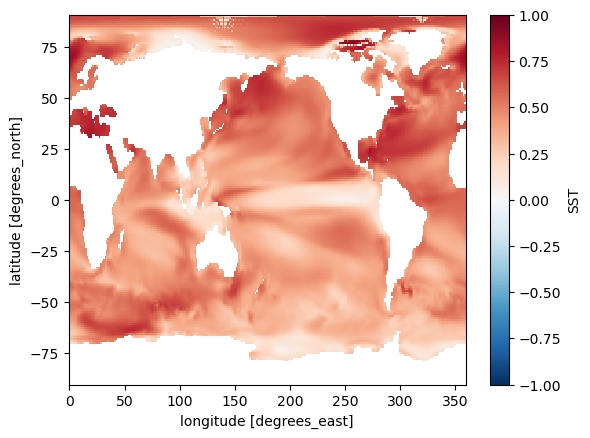

In [10]:
da = cfg_var_SST.LE_ds['SST'].sel(year=slice(1965, 2020))

# 1) 0을 NaN으로
da = da.where(~np.isclose(da, 0), np.nan)

# 2) 1년 뒤 데이터(shift) 만들기
da_lag1 = da.shift(year=-1)

# 3) 양쪽 모두 유효한 연도만 남기기
valid = (~np.isnan(da)) & (~np.isnan(da_lag1))
da      = da.where(valid)
da_lag1 = da_lag1.where(valid)

# 4) lag-1 상관 (year 차원)
autocorr_SST_LE = xr.corr(da, da_lag1, dim='year')   # ens_LE, lat, lon

# 예: ensemble 평균 맵
autocorr_SST_LE.mean(dim='ens_LE').plot.pcolormesh(vmin=-1, vmax=1, cmap='RdBu_r')

In [11]:
da = cfg_var_SST.LE_ds['SST'].sel(year=slice(1965, 2020)).mean(dim='ens_LE')

da = da.where(~np.isclose(da, 0), np.nan)
da_lag1 = da.shift(year=-1)
valid = (~np.isnan(da)) & (~np.isnan(da_lag1))
da      = da.where(valid)
da_lag1 = da_lag1.where(valid)
autocorr_SST_LE_em = xr.corr(da, da_lag1, dim='year')   # ens_LE, lat, lon

In [12]:
da = cfg_var_SST.LE_ds_4yr['SST'].sel(year=slice(1965, 2020))

da = da.where(~np.isclose(da, 0), np.nan)
da_lag1 = da.shift(year=-1)
valid = (~np.isnan(da)) & (~np.isnan(da_lag1))
da      = da.where(valid)
da_lag1 = da_lag1.where(valid)

autocorr_SST_LE_ds_4yr = xr.corr(da, da_lag1, dim='year')   # ens_LE, lat, lon

In [13]:
da = cfg_var_SST.LE_ds_4yr['SST'].sel(year=slice(1965, 2020)).mean(dim='ens_LE')

da = da.where(~np.isclose(da, 0), np.nan)
da_lag1 = da.shift(year=-1)
valid = (~np.isnan(da)) & (~np.isnan(da_lag1))
da      = da.where(valid)
da_lag1 = da_lag1.where(valid)

autocorr_SST_LE_ds_4yr_em = xr.corr(da, da_lag1, dim='year')   # ens_LE, lat, lon

In [14]:
da = cfg_var_SST.HCST_ds_yearly['SST'].sel(year=slice(1965, 2020))

da = da.where(~np.isclose(da, 0), np.nan)
da_lag1 = da.shift(year=-1)
valid = (~np.isnan(da)) & (~np.isnan(da_lag1))
da      = da.where(valid)
da_lag1 = da_lag1.where(valid)

autocorr_SST_HCST = xr.corr(da, da_lag1, dim='year')   # ens_LE, lat, lon

In [15]:
da = cfg_var_SST.HCST_ds_yearly['SST'].sel(year=slice(1965, 2020)).mean(dim='ens_HCST')

da = da.where(~np.isclose(da, 0), np.nan)
da_lag1 = da.shift(year=-1)
valid = (~np.isnan(da)) & (~np.isnan(da_lag1))
da      = da.where(valid)
da_lag1 = da_lag1.where(valid)

autocorr_SST_HCST_em = xr.corr(da, da_lag1, dim='year')   # ens_LE, lat, lon

In [16]:
da = cfg_var_SST.HCST_ds_4yr['SST'].sel(year=slice(1965, 2020))

da = da.where(~np.isclose(da, 0), np.nan)
da_lag1 = da.shift(year=-1)
valid = (~np.isnan(da)) & (~np.isnan(da_lag1))
da      = da.where(valid)
da_lag1 = da_lag1.where(valid)

autocorr_SST_HCST_ds_4yr = xr.corr(da, da_lag1, dim='year')   # ens_LE, lat, lon

In [17]:
da = cfg_var_SST.HCST_ds_4yr['SST'].sel(year=slice(1965, 2020)).mean(dim='ens_HCST')

da = da.where(~np.isclose(da, 0), np.nan)
da_lag1 = da.shift(year=-1)
valid = (~np.isnan(da)) & (~np.isnan(da_lag1))
da      = da.where(valid)
da_lag1 = da_lag1.where(valid)

autocorr_SST_HCST_ds_4yr_em = xr.corr(da, da_lag1, dim='year')   # ens_LE, lat, lon

In [35]:
def process_coords_obs(ds, drop=True, except_coord_vars=['time','valid_time', 'lon','lat', 'TLONG', 'TLAT', 'sst', 'PP', 'sla', 'SOMXL030', 'NAV_LON', 'NAV_LAT', 'u10', 'v10']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    # ds = ds.where(mask, drop=True)
    # volume= ds_grid_sub['dz'] * ds_grid_sub['TAREA']
    # weighted_sum = (ds[varname] * volume).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # effective_volume = volume.where(ds[varname].notnull()).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # ds[varname] = weighted_sum / effective_volume
    if 'valid_time' in ds:
        ds = ds.rename({'valid_time': 'time'})
    
    if drop:
        ds= ds.drop(coord_vars)
        return ds
    else:
        return ds.set_coords(coord_vars)

In [36]:
# Read Observation dataset (SST)
start_time = time.time()

# SST
cfg_var_SST.OBS_path_load(cfg_var_SST.var)
dname=cfg_var_SST.OBS_var
cfg_var_SST.OBS_ds = xr.open_mfdataset(
    cfg_var_SST.OBS_file_list[0][0],
    chunks={'time': 12},
    parallel=True,
    preprocess=lambda ds: process_coords_obs(ds),
    combine="by_coords",
    decode_times=True,  # skip calendar/time decoding
)

cfg_var_SST.OBS_ds = cfg_var_SST.OBS_ds.rename({cfg_var_SST.OBS_var: cfg_var_SST.var})

# # global mean removal for SSH
# if cfg_var_SST.var=='SSH':
#     lat_mask = (ds_grid.TLAT >= -60) & (ds_grid.TLAT <= 60)

#     area_selected = ds_grid.TAREA.where(lat_mask, drop=True)  # 선택된 지역의 면적
#     ssh_selected = cfg_var_SST.OBS_ds[cfg_var_SST.var].where(lat_mask, drop=True)  # 선택된 지역의 SSH 데이터

#     # 필터링된 지역에 대해 global mean 계산
#     cfg_var_SST.OBS_ds['gm'] = (ssh_selected * area_selected).sum(dim=['nlat', 'nlon']) / area_selected.sum(dim=['nlat', 'nlon'])
    
#     # 원 데이터에서 global mean을 제거한 값
#     cfg_var_SST.OBS_ds['SSH'] = cfg_var_SST.OBS_ds[cfg_var_SST.var] - cfg_var_SST.OBS_ds['gm']


# cfg_var_SST.OBS_ds = cfg_var_SST.OBS_ds.where(mask, drop=True)
# area = ds_grid_sub['TAREA']
# weighted_sum = (cfg_var_SST.OBS_ds['SST'] * area).sum(dim=['nlat','nlon'], skipna=True)
# effective_area = area.where(cfg_var_SST.OBS_ds['SST'].notnull()).sum(dim=['nlat','nlon'], skipna=True)
# cfg_var_SST.OBS_ds['SST'] = weighted_sum / effective_area

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))

elasped time for reading OBS: 5.719463109970093


In [80]:
# read atm_grid
ds_grid_atm = xr.open_dataset('/proj/kimyy/Observation/ERA5/grid_atm.nc')

mask_obs_glo = ((cfg_var_SST.OBS_ds.lon >= 0) 
        & (cfg_var_SST.OBS_ds.lon <= 360) 
        & (cfg_var_SST.OBS_ds.lat >= -60) 
        & (cfg_var_SST.OBS_ds.lat <= 60))
ds_grid_atm_glo = ds_grid_atm.where(mask_obs_glo, drop=True)
area_glo = ds_grid_atm_glo['AREA'].isel(time=0)


mask_obs_atl = ((cfg_var_SST.OBS_ds.lon >= 280) 
        & (cfg_var_SST.OBS_ds.lon <= 360) 
        & (cfg_var_SST.OBS_ds.lat >= 0) 
        & (cfg_var_SST.OBS_ds.lat <= 60))
ds_grid_atm_atl = ds_grid_atm.where(mask_obs_atl, drop=True)
area_atl = ds_grid_atm_atl['AREA'].isel(time=0)

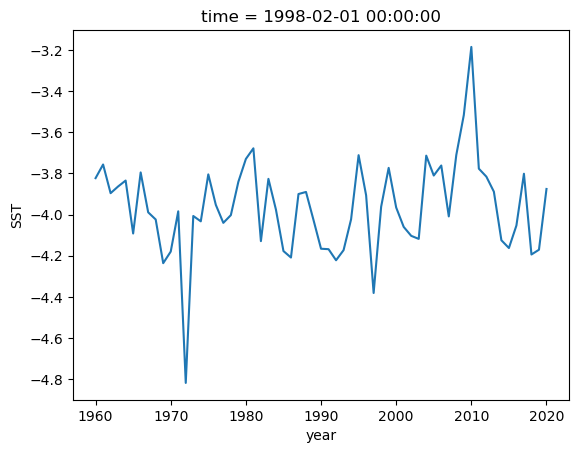

In [84]:
# # OBS AMV calculation
# cfg_var_SST.OBS_ds_yearly = cfg_var_SST.OBS_ds.groupby('time.year').mean(dim='time') 

# obs_tmp_glo = cfg_var_SST.OBS_ds_yearly.where(mask_obs_glo, drop=True)

# null_mask_glo = obs_tmp_glo.isel(year=0).notnull()     # NaN 이 아닌 곳만 True
# area_glo_masked = area_glo.where(null_mask_glo, np.nan)

# obs_tmp_glo_aream = obs_tmp_glo['SST'] * area_glo_masked['SST']
# # obs_tmp_glo_aream.where(~np.isclose(obs_tmp_glo_aream, 0), np.nan)
# obs_tmp_glo_aream = obs_tmp_glo_aream.sum(dim=['lon', 'lat'])
# area_glo_masked_sum = area_glo_masked.sum(dim=['lon', 'lat'])

# obs_glo = obs_tmp_glo_aream / area_glo_masked_sum

# obs_tmp_atl = cfg_var_SST.OBS_ds_yearly.where(mask_obs_atl, drop=True)

# null_mask_atl = obs_tmp_atl.isel(year=0).notnull()     # NaN 이 아닌 곳만 True
# area_atl_masked = area_atl.where(null_mask_atl, np.nan)

# # obs_tmp_atl_aream = obs_tmp_atl['SST'] * area_atl_masked['SST']
# # obs_tmp_atl_aream = obs_tmp_atl_aream.sum(dim=['lon', 'lat'])
# # area_atl_masked_sum = area_atl_masked.sum(dim=['lon', 'lat'])

# # obs_atl = obs_tmp_atl_aream / area_atl_masked_sum
# # obs_atl['SST'].plot()

# obs_tmp_AMO = obs_tmp_atl - obs_glo*beta
# obs_tmp_AMO_aream = obs_tmp_AMO * area_atl_masked['SST']
# obs_tmp_AMO_aream = obs_tmp_AMO_aream.sum(dim=['lon', 'lat'])
# area_atl_masked_sum = area_atl_masked.sum(dim=['lon', 'lat'])
# obs_AMO = obs_tmp_AMO_aream / area_atl_masked_sum


# obs_AMO['SST'].plot()


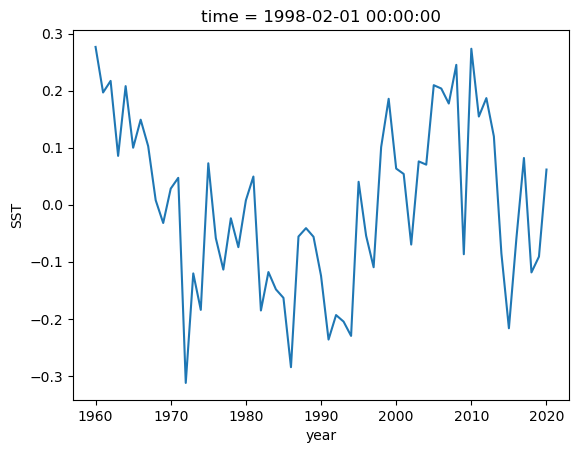

In [163]:
ds_ann = cfg_var_SST.OBS_ds.groupby('time.year').mean('time')
ds_ann = ds_ann.where(ds_ann >= -2)

# 1) Global 마스크 : SST 변수만 사용
sst_gl = ds_ann['SST'].where(mask_obs_glo)                # DataArray(year,lat,lon)
area_gl_mask = area_glo.where(sst_gl.notnull().all('year'))

x_gl = (sst_gl * area_gl_mask).sum(('lon','lat')) / area_gl_mask.sum(('lon','lat'))

# 2) Atlantic
sst_atl = ds_ann['SST'].where(mask_obs_atl)
area_atl_mask = area_atl.where(sst_atl.notnull().all('year'))

# 3) 회귀계수
x_anom = x_gl - x_gl.mean('year')                         # (year)
y_anom = sst_atl - sst_atl.mean('year')                   # (year,lat,lon)

beta = xr.cov(x_anom, y_anom, dim='year') / x_anom.var('year')   # (lat,lon)

# 4) 회귀 제거
x_bc   = x_anom.broadcast_like(y_anom)                    # (year,lat,lon)
sst_reg_removed = y_anom - beta * x_bc                   # 확실한 브로드캐스트

# 5) AMO
amo_num = (sst_reg_removed * area_atl_mask).sum(('lon','lat'))
amo_den = area_atl_mask.sum(('lon','lat'))
obs_AMO     = (amo_num / amo_den)               # (year)

obs_AMO['SST'].plot()

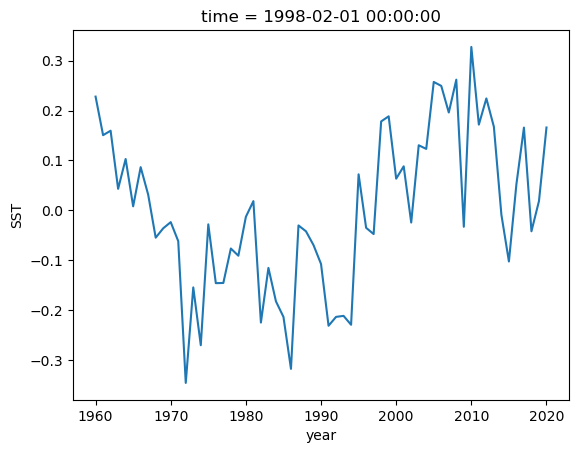

In [150]:
ds_ann = cfg_var_SST.OBS_ds.groupby('time.year').mean('time')
ds_ann = ds_ann.where(ds_ann >= -2)

# 1) Global 마스크 : SST 변수만 사용
sst_gl = ds_ann['SST'].where(mask_obs_glo)                # DataArray(year,lat,lon)
area_gl_mask = area_glo.where(sst_gl.notnull().all('year'))

x_gl = (sst_gl * area_gl_mask).sum(('lon','lat')) / area_gl_mask.sum(('lon','lat'))

# 2) Atlantic
sst_atl = ds_ann['SST'].where(mask_obs_atl)
area_atl_mask = area_atl.where(sst_atl.notnull().all('year'))

# # 3) 회귀계수
x_anom = x_gl - x_gl.mean('year')                         # (year)
y_anom = sst_atl - sst_atl.mean('year')                   # (year,lat,lon)

# beta = xr.cov(x_anom, y_anom, dim='year') / x_anom.var('year')   # (lat,lon)

# # 4) 회귀 제거
x_bc   = x_anom.broadcast_like(y_anom)                    # (year,lat,lon)
sst_reg_removed = y_anom - x_bc                   # 확실한 브로드캐스트

# 5) AMO
amo_num = (sst_reg_removed * area_atl_mask).sum(('lon','lat'))
amo_den = area_atl_mask.sum(('lon','lat'))
obs_AMO_tren     = (amo_num / amo_den)               # (year)

obs_AMO_tren['SST'].plot()

In [132]:


ds_grid_atm_model = ds_grid_atm
ds_grid_atm_model['lat'] = ds_grid_atm_model['lat'].round(4)
ds_grid_atm_model['lon'] = ds_grid_atm_model['lon'].round(4)



mask_hcst_glo = ((cfg_var_SST.HCST_ds_yearly.lon >= 0) 
        & (cfg_var_SST.HCST_ds_yearly.lon <= 360) 
        & (cfg_var_SST.HCST_ds_yearly.lat >= -60) 
        & (cfg_var_SST.HCST_ds_yearly.lat <= 60))
ds_grid_atm_model_glo = ds_grid_atm_model.where(mask_hcst_glo, drop=True)
area_model_glo = ds_grid_atm_model_glo['AREA'].isel(time=0)

mask_hcst_atl = ((cfg_var_SST.HCST_ds_yearly.lon >= 280) 
        & (cfg_var_SST.HCST_ds_yearly.lon <= 360) 
        & (cfg_var_SST.HCST_ds_yearly.lat >= 0) 
        & (cfg_var_SST.HCST_ds_yearly.lat <= 60))
ds_grid_atm_model_atl = ds_grid_atm_model.where(mask_hcst_atl, drop=True)
area_model_atl = ds_grid_atm_model_atl['AREA'].isel(time=0)

In [214]:
ds_ann = cfg_var_SST.ODA_ds
ds_ann = ds_ann.where(~np.isclose(ds_ann['SST'], 0), np.nan)
ds_ann = ds_ann.where(ds_ann >= 271.15)

# 1) Global 마스크 : SST 변수만 사용
sst_gl = ds_ann['SST'].where(mask_hcst_glo)                # DataArray(year,lat,lon)
area_gl_mask = area_model_glo.where(sst_gl.notnull().all('year'))

x_gl = (sst_gl * area_gl_mask).sum(('lon','lat')) / area_gl_mask.sum(('lon','lat'))

# 2) Atlantic
sst_atl = ds_ann['SST'].where(mask_hcst_atl)
area_atl_mask = area_model_atl.where(sst_atl.notnull().all('year'))

# 3) 회귀계수
x_anom = x_gl - x_gl.mean('year')                         # (year)
y_anom = sst_atl - sst_atl.mean('year')                   # (year,lat,lon)

beta = xr.cov(x_anom, y_anom, dim='year') / x_anom.var('year')   # (lat,lon)

# 4) 회귀 제거
x_bc   = x_anom.broadcast_like(y_anom)                    # (year,lat,lon)
sst_reg_removed = y_anom - beta * x_bc                   # 확실한 브로드캐스트

# 5) AMO
amo_num = (sst_reg_removed * area_atl_mask).sum(('lon','lat'))
amo_den = area_atl_mask.sum(('lon','lat'))
oda_AMO     = (amo_num / amo_den)               # (year)

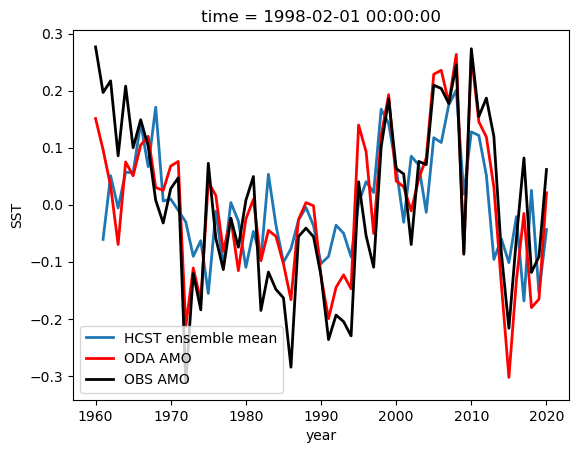

In [217]:
ds_ann = cfg_var_SST.HCST_ds_yearly
ds_ann = ds_ann.where(~np.isclose(ds_ann['SST'], 0), np.nan)
ds_ann = ds_ann.where(ds_ann >= 271.15)

# 1) Global 마스크 : SST 변수만 사용
sst_gl = ds_ann['SST'].where(mask_hcst_glo)                # DataArray(year,lat,lon)
area_gl_mask = area_model_glo.where(sst_gl.notnull().all('year'))

x_gl = (sst_gl * area_gl_mask).sum(('lon','lat')) / area_gl_mask.sum(('lon','lat'))

# 2) Atlantic
sst_atl = ds_ann['SST'].where(mask_hcst_atl)
area_atl_mask = area_model_atl.where(sst_atl.notnull().all('year'))

# 3) 회귀계수
x_anom = x_gl - x_gl.mean('year')                         # (year)
y_anom = sst_atl - sst_atl.mean('year')                   # (year,lat,lon)

beta = xr.cov(x_anom, y_anom, dim='year') / x_anom.var('year')   # (lat,lon)

# 4) 회귀 제거
x_bc   = x_anom.broadcast_like(y_anom)                    # (year,lat,lon)
sst_reg_removed = y_anom - beta * x_bc                   # 확실한 브로드캐스트

# 5) AMO
amo_num = (sst_reg_removed * area_atl_mask).sum(('lon','lat'))
amo_den = area_atl_mask.sum(('lon','lat'))
hcst_AMO     = (amo_num / amo_den)               # (year)



fig, ax = plt.subplots()

hcst_AMO.mean(dim='ens_HCST').plot(
    ax=ax, label='HCST ensemble mean', linewidth=2)

oda_AMO.mean(dim='ens_ODA').plot(
    ax=ax, label='ODA AMO', color='red', linewidth=2)

obs_AMO['SST'].plot(
    ax=ax, label='OBS AMO', color='black', linewidth=2)

ax.legend(loc='best')
plt.show()

In [218]:
xr.corr(hcst_AMO.mean(dim='ens_HCST'), oda_AMO.mean(dim='ens_ODA'))

<xarray.DataArray ()> Size: 8B
array(0.6956962)
Coordinates:
    lyears   int64 8B 1
    time     object 8B 1998-02-01 00:00:00

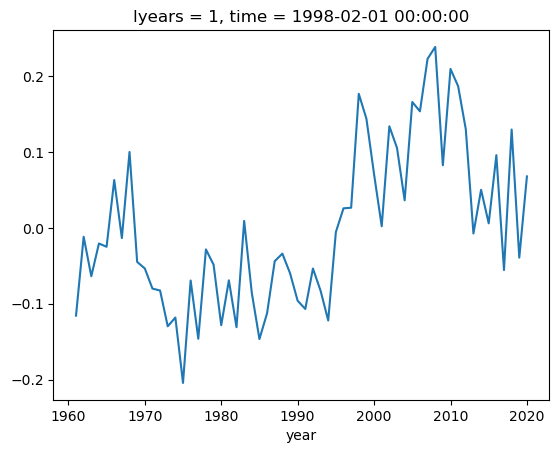

In [151]:
ds_ann = cfg_var_SST.HCST_ds_yearly
ds_ann = ds_ann.where(~np.isclose(ds_ann['SST'], 0), np.nan)
ds_ann = ds_ann.where(ds_ann >= 271.15)

# 1) Global 마스크 : SST 변수만 사용
sst_gl = ds_ann['SST'].where(mask_hcst_glo)                # DataArray(year,lat,lon)
area_gl_mask = area_model_glo.where(sst_gl.notnull().all('year'))

x_gl = (sst_gl * area_gl_mask).sum(('lon','lat')) / area_gl_mask.sum(('lon','lat'))

# 2) Atlantic
sst_atl = ds_ann['SST'].where(mask_hcst_atl)
area_atl_mask = area_model_atl.where(sst_atl.notnull().all('year'))

# 3) 회귀계수
x_anom = x_gl - x_gl.mean('year')                         # (year)
y_anom = sst_atl - sst_atl.mean('year')                   # (year,lat,lon)

beta = xr.cov(x_anom, y_anom, dim='year') / x_anom.var('year')   # (lat,lon)

# 4) 회귀 제거
x_bc   = x_anom.broadcast_like(y_anom)                    # (year,lat,lon)
sst_reg_removed = y_anom -  x_bc                   # 확실한 브로드캐스트

# 5) AMO
amo_num = (sst_reg_removed * area_atl_mask).sum(('lon','lat'))
amo_den = area_atl_mask.sum(('lon','lat'))
hcst_AMO_tren     = (amo_num / amo_den)               # (year)

hcst_AMO_tren.mean(dim='ens_HCST').plot()



True

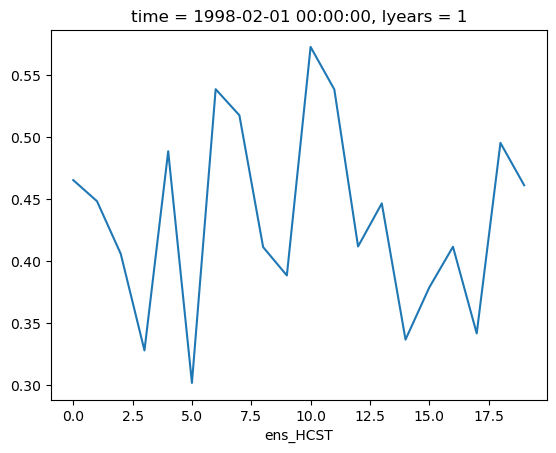

In [220]:
corr_hcst_ly1 = xr.corr(obs_AMO['SST'].sel(year=slice(1965, 2020)), hcst_AMO.sel(year=slice(1965, 2020)), dim='year')
corr_hcst_ly1.plot()

obs_AMO_lag1 = obs_AMO.shift(year=-1)
valid = (~np.isnan(obs_AMO)) & (~np.isnan(obs_AMO_lag1))
obs_AMO_tmp      = obs_AMO.where(valid)
obs_AMO_lag1 = obs_AMO_lag1.where(valid)

oda_AMO_lag1 = oda_AMO.shift(year=-1)
valid = (~np.isnan(oda_AMO)) & (~np.isnan(hcst_AMO_lag1))
oda_AMO_tmp      = oda_AMO.where(valid)
oda_AMO_lag1 = oda_AMO_lag1.where(valid)

hcst_AMO_lag1 = hcst_AMO.shift(year=-1)
valid = (~np.isnan(hcst_AMO)) & (~np.isnan(hcst_AMO_lag1))
hcst_AMO_tmp      = hcst_AMO.where(valid)
hcst_AMO_lag1 = hcst_AMO_lag1.where(valid)

oda_AMO_em_lag1 = oda_AMO.mean(dim='ens_ODA').shift(year=-1)
valid = (~np.isnan(oda_AMO.mean(dim='ens_ODA'))) & (~np.isnan(oda_AMO_em_lag1))
oda_AMO_em_tmp      = oda_AMO.mean(dim='ens_ODA').where(valid)
oda_AMO_em_lag1 = oda_AMO_em_lag1.where(valid)

hcst_AMO_em_lag1 = hcst_AMO.mean(dim='ens_HCST').shift(year=-1)
valid = (~np.isnan(hcst_AMO.mean(dim='ens_HCST'))) & (~np.isnan(hcst_AMO_em_lag1))
hcst_AMO_em_tmp      = hcst_AMO.mean(dim='ens_HCST').where(valid)
hcst_AMO_em_lag1 = hcst_AMO_em_lag1.where(valid)

autocorr_SST_obs_AMO_deser = xr.corr(obs_AMO_tmp['SST'], obs_AMO_lag1['SST'], dim='year')   # ens_LE, lat, lon
autocorr_SST_hcst_AMO_deser = xr.corr(hcst_AMO_tmp, hcst_AMO_lag1, dim='year')   # ens_LE, lat, lon
autocorr_SST_hcst_em_AMO_deser = xr.corr(hcst_AMO_em_tmp, hcst_AMO_em_lag1, dim='year')   # ens_LE, lat, lon
autocorr_SST_oda_em_AMO_deser = xr.corr(oda_AMO_em_tmp, oda_AMO_em_lag1, dim='year')   # ens_LE, lat, lon


autocorr_SST_hcst_AMO_deser
n=56
# edof_deser=n*(1-autocorr_SST_hcst_AMO_deser)/(1+autocorr_SST_hcst_AMO_deser)
edof_deser=n*(1-autocorr_SST_hcst_AMO_deser*autocorr_SST_obs_AMO_deser)/(1+autocorr_SST_hcst_AMO_deser*autocorr_SST_obs_AMO_deser)
edof_em_deser=n*(1-autocorr_SST_hcst_em_AMO_deser*autocorr_SST_obs_AMO_deser)/(1+autocorr_SST_hcst_em_AMO_deser*autocorr_SST_obs_AMO_deser)
edof_oda_em_deser=n*(1-autocorr_SST_hcst_em_AMO_deser*autocorr_SST_oda_em_AMO_deser)/(1+autocorr_SST_hcst_em_AMO_deser*autocorr_SST_oda_em_AMO_deser)

edof_deser



# 1. 중앙값
median_val = corr_hcst_ly1.quantile(0.5, dim='ens_HCST')  # shape: ()

# 2. 각 멤버의 값과 median 의 차이
abs_diff = np.abs(corr_hcst_ly1 - median_val)

# 3. 차이가 가장 작은 멤버의 인덱스 (0~19)
idx_closest = abs_diff.argmin(dim='ens_HCST')

# 4. 해당 인덱스를 가진 값
value_closest = corr_hcst_ly1.isel(ens_HCST=idx_closest.values)
edof_closest = edof_deser.isel(ens_HCST=idx_closest.values)


t_stat = value_closest * (edof_closest**0.5) / ((1 - value_closest**2)**0.5)

# p-value (양측)
pval = 2 * (1 - t.cdf(abs(t_stat), df=edof_closest))

# 결과 판단
alpha = 0.1
significant = pval < alpha

#26.47134243 = edof

# print(f"value_closest = {value_closest:.3f}, edof_closest = {edof_closest:.1f}, t = {t_stat:.3f}, p = {pval:.4f}")
# print(f"→ Significant at 90%? {'Yes' if significant else 'No'}")
significant

In [223]:
edof_oda_em_deser.values

array(32.83103129)

In [222]:
edof_em_deser.values

array(31.37150777)

In [203]:
edof_closest.values

array(38.67946476)

In [204]:
value_closest.values

array(0.4118925)

<xarray.DataArray (ens_HCST: 20)> Size: 80B
array([24.664173 , 26.407967 , 36.627422 , 34.808907 , 20.54785  ,
       38.428864 , 25.214922 , 32.17923  , 27.254194 , 22.316858 ,
       25.576086 , 18.137007 , 14.251734 , 20.944313 , 13.8433695,
       28.001749 , 19.161911 , 21.822731 , 16.179852 , 20.819519 ],
      dtype=float32)
Coordinates:
  * ens_HCST  (ens_HCST) int64 160B 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
    lyears    int64 8B 1
    time      object 8B 1998-02-01 00:00:00

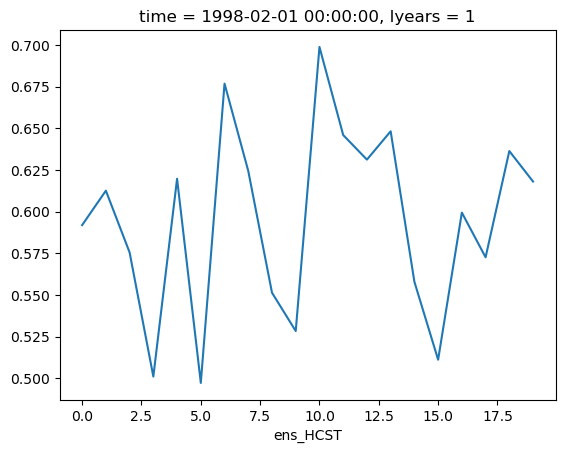

In [154]:

corr_hcst_tren_ly1 = xr.corr(obs_AMO_tren['SST'].sel(year=slice(1965, 2020)), hcst_AMO_tren.sel(year=slice(1965, 2020)), dim='year')
corr_hcst_tren_ly1.plot()

hcst_AMO_tren_lag1 = hcst_AMO_tren.shift(year=-1)
valid = (~np.isnan(hcst_AMO_tren)) & (~np.isnan(hcst_AMO_tren_lag1))
hcst_AMO_tren_tmp      = hcst_AMO_tren.where(valid)
hcst_AMO_tren_lag1 = hcst_AMO_tren_lag1.where(valid)

autocorr_SST_hcst_AMO_tren = xr.corr(hcst_AMO_tren_tmp, hcst_AMO_tren_lag1, dim='year')   # ens_LE, lat, lon

autocorr_SST_hcst_AMO_tren
n=56
edof_tren=n*(1-autocorr_SST_hcst_AMO_tren)/(1+autocorr_SST_hcst_AMO_tren)
edof_tren

In [45]:
# Atlantic region = 280 360 0 60
# GlO region = 0 360 -60 60

#area-weighted mean is needed.

tmp_glo = cfg_var_SST.HCST_ds_yearly['SST'].sel(year=slice(1965, 2020)).sel(lon=slice(0,360)).sel(lat=slice(-60,60))
tmp_glo.where(~np.isclose(tmp_glo, 0), np.nan)
tmp_glo_mean=tmp_glo.mean(dim=['lon', 'lat'])
tmp_atl = cfg_var_SST.HCST_ds_yearly['SST'].sel(year=slice(1965, 2020)).sel(lon=slice(280,360)).sel(lat=slice(0,60))
tmp_atl.where(~np.isclose(tmp_atl, 0), np.nan)
tmp_atl_mean=tmp_atl.mean(dim=['lon', 'lat'])
cfg_var_SST.HCST_AMV_tren=tmp_atl_mean-tmp_glo_mean
# cfg_var_SST.HCST_AMV_tren.sel(ens_HCST=0).plot()


cfg_var_SST.HCST_AMV_tren_lag1 = cfg_var_SST.HCST_AMV_tren.shift(year=-1)
valid = (~np.isnan(cfg_var_SST.HCST_AMV_tren)) & (~np.isnan(cfg_var_SST.HCST_AMV_tren_lag1))
cfg_var_SST.HCST_AMV_tren      = cfg_var_SST.HCST_AMV_tren.where(valid)
cfg_var_SST.HCST_AMV_tren_lag1 = cfg_var_SST.HCST_AMV_tren_lag1.where(valid)

autocorr_SST_HCST_AMV_tren = xr.corr(cfg_var_SST.HCST_AMV_tren, cfg_var_SST.HCST_AMV_tren_lag1, dim='year')   # ens_LE, lat, lon
autocorr_SST_HCST_AMV_tren
n=56
edof=n*(1-autocorr_SST_HCST_AMV_tren)/(1+autocorr_SST_HCST_AMV_tren)
edof
# sig_n_star(sig_n_star<=2)=NaN;
# sig_t=tmp.C.*sqrt(sig_n_star-2)./sqrt((1-tmp.C.^2));
# sig_tcdf=tcdf(sig_t,sig_n_star-2);
# for loni=1:size(tmp.C,1)
#     for lati=1:size(tmp.C,2)
#         if tmp.C(loni,lati)>=0
#             tmp.p(loni,lati)=2*(1-sig_tcdf(loni,lati)); % r=positive
#         elseif tmp.C(loni,lati)<0
#             tmp.p(loni,lati)=2*(sig_tcdf(loni,lati)); % r=negative
#         end
#     end
# end


<xarray.DataArray 'SST' (ens_HCST: 20)> Size: 80B
array([21.561087, 18.960943, 28.100557, 23.474112, 16.359873, 27.178368,
       18.03237 , 19.5091  , 17.148129, 17.375011, 15.52676 , 14.547556,
        9.700166, 16.77206 , 10.163544, 21.064047, 13.006169, 14.771424,
       12.576233, 15.758076], dtype=float32)
Coordinates:
    lyears    int64 8B 1
  * ens_HCST  (ens_HCST) int64 160B 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19

In [224]:
# critical r with alpha=0.1, alpha=0.34
N = 31
alpha = 0.1  # two-sided, so alpha/2 = 0.05
df = N - 2

# 1) Find t_crit for a two-sided test at alpha=0.1
t_crit = t.ppf(1 - alpha/2, df)  # e.g., ppf(0.95) for the upper 5% tail

# 2) Solve for the correlation threshold
rho_crit = np.sqrt(t_crit**2 / ((N - 2) + t_crit**2))
print(f"N={N}, alpha={alpha}, df={df}")
print(f"t_crit = {t_crit:.3f}")
print(f"Correlation threshold ≈ ±{rho_crit:.3f}")

N=31, alpha=0.1, df=29
t_crit = 1.699
Correlation threshold ≈ ±0.301


In [18]:
# # save temporary file (HCST)
# start_time = time.time()

# autocorr_SST_LE.to_netcdf(savefilepath + "/autocorr_SST_LE" + ".nc")
# autocorr_SST_LE_em.to_netcdf(savefilepath + "/autocorr_SST_LE_em" + ".nc")
# autocorr_SST_LE_ds_4yr.to_netcdf(savefilepath + "/autocorr_SST_LE_ds_4yr" + ".nc")
# autocorr_SST_LE_ds_4yr_em.to_netcdf(savefilepath + "/autocorr_SST_LE_ds_4yr_em" + ".nc")
# autocorr_SST_HCST.to_netcdf(savefilepath + "/autocorr_SST_HCST" + ".nc")
# autocorr_SST_HCST_em.to_netcdf(savefilepath + "/autocorr_SST_HCST_em" + ".nc")
# autocorr_SST_HCST_ds_4yr.to_netcdf(savefilepath + "/autocorr_SST_HCST_ds_4yr" + ".nc")
# autocorr_SST_HCST_ds_4yr_em.to_netcdf(savefilepath + "/autocorr_SST_HCST_ds_4yr_em" + ".nc")

# end_time = time.time()
# elapsed_time = end_time - start_time
# print('elasped time for saving SST corr, ' + str(iyear) + ': ' + str(elapsed_time))